In [1]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
link = 'https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast/files/7768846/Time_series_analysis_and_forecast_DATASET.csv'
data = pd.read_csv(link, encoding = 'latin-1')
data.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [3]:
# Converting the FullDate column into Date time
data['FullDate'] = pd.to_datetime(data['FullDate'])
data.describe()

,Tmax,SysLoad,GasPrice,ElecPrice
count,92016.000000,92016.000000,92016.000000,92016.000000
mean,231.696688,797.623357,6.016163,65.798356
std,4562.128748,613.520156,2.608116,213.144084
min,9.900000,-1596.810100,0.000000,-924.820000
25%,17.300000,417.119800,3.936900,31.543750
50%,21.900000,856.467925,5.165600,48.715000
75%,27.600000,1221.293675,8.023300,76.495000
max,99999.900000,3264.166300,29.990000,14700.000000


In [4]:
data.set_index('FullDate', inplace = True) # Set FullDate as an index

Text(0.5, 1.0, 'Electricity Price over a time')

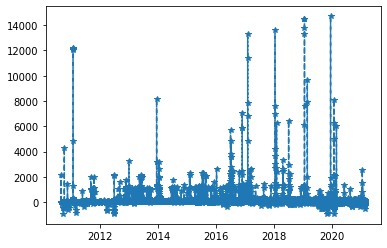

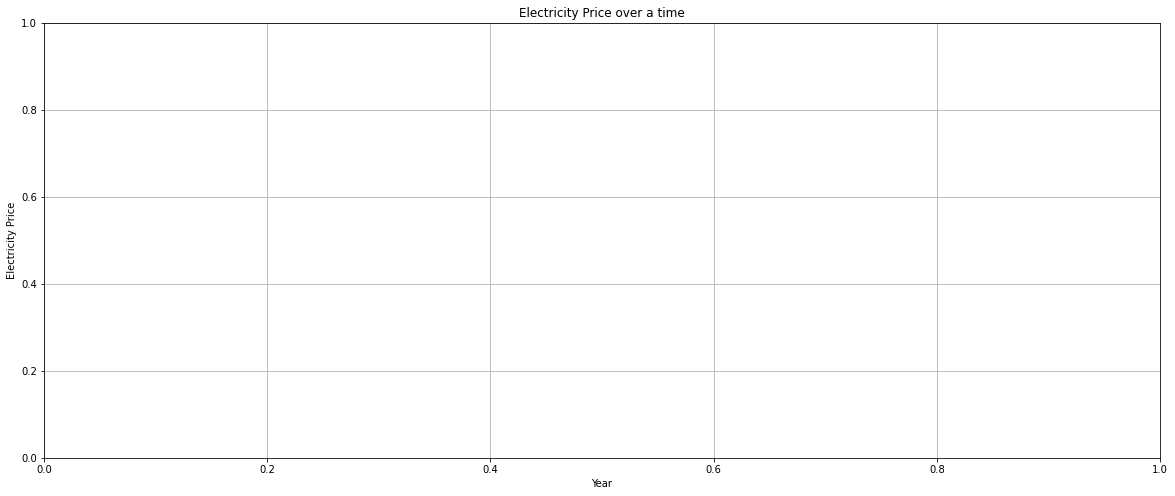

In [5]:
plt.plot(data.index, data.ElecPrice, '--', marker='*')
plt.figure(figsize=(20,8)) 
plt.grid()
plt.xlabel('Year')
plt.ylabel('Electricity Price')
plt.title('Electricity Price over a time')

Text(0.5, 1.0, 'Electricity Price over a time (sampled Data)')

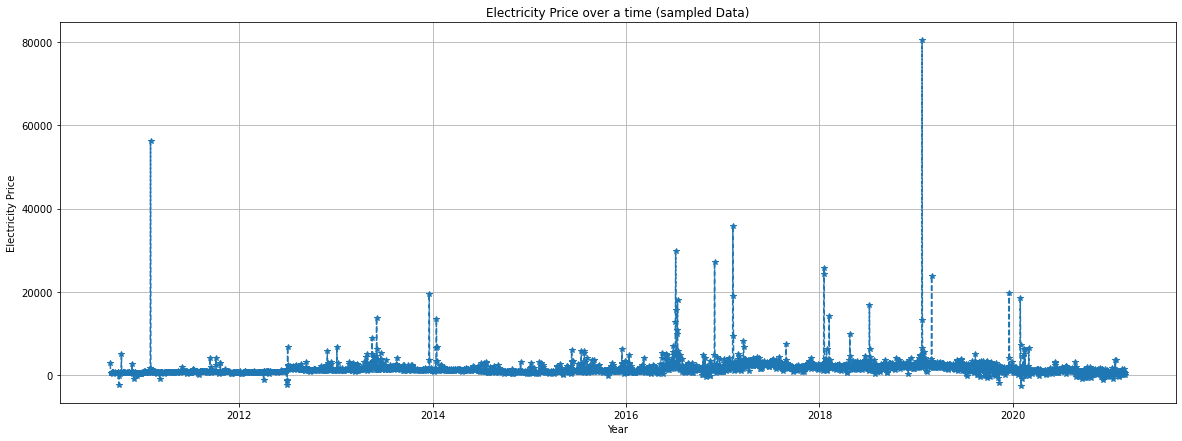

In [6]:
#Plot of ElecPrice over time
quarter_rate = data.resample('3M').sum()
daily_rate = data.resample('D').sum()
plt.figure(figsize= (20,7) )
plt.plot(daily_rate.index, daily_rate.ElecPrice, '--', marker='*')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Electricity Price')
plt.title('Electricity Price over a time (sampled Data)')

In [7]:
# Display the information of ADF test
def display_adfuller_info(adfull):
  print(f'ADF Statistic: {adfull[0]}')
  print(f'p-value: {adfull[1]}')
  print(f'No. of lags used: {adfull[2]}')
  print(f'No. of observations used : {adfull[3]}')
  print('Critical Values:')
  for k, v in adfull[4].items():
      print(f' {k}: {v}')

In [8]:
sys_load = adfuller(daily_rate['SysLoad'])
display_adfuller_info(sys_load)

ADF Statistic: -3.6901589888366457
p-value: 0.004253725504574117
No. of lags used: 30
No. of observations used : 3803
Critical Values:
 1%: -3.432070672988693
 5%: -2.8623002987378547
 10%: -2.567174716967499


In [9]:
gas_price = adfuller(daily_rate['GasPrice'])
display_adfuller_info(gas_price)

ADF Statistic: -2.90276669716518
p-value: 0.04502721288462542
No. of lags used: 27
No. of observations used : 3806
Critical Values:
 1%: -3.4320693157877544
 5%: -2.8622996992165364
 10%: -2.5671743978048323


In [10]:
elec_price = adfuller(daily_rate['ElecPrice'])
display_adfuller_info(elec_price)

ADF Statistic: -8.269053866873803
p-value: 4.848817773711633e-13
No. of lags used: 20
No. of observations used : 3813
Critical Values:
 1%: -3.432066157296446
 5%: -2.8622983040036005
 10%: -2.5671736550459663


In [11]:
round(sys_load[1],6)

0.004254

In [12]:
round(gas_price[1],6)

0.045027

In [13]:
round(gas_price[4]["10%"],4)

-2.5672

In [14]:
round(elec_price[4]["5%"],4)

-2.8623

Univariate Time Series Model

In [15]:
# Splitting the daily sampled rate into train and test 
train_data = daily_rate.iloc[:2757,:]
test_data = daily_rate.iloc[2757:,:]
train_data.shape , test_data.shape

((2757, 4), (1077, 4))

In [16]:
# Reset the index
train_data.reset_index(inplace = True)
train_data.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [17]:
# Rename the columns
df_train = train_data.iloc[:,[0,-1]]
df_train = df_train.rename(columns={"FullDate": "ds", "ElecPrice": "y"})
df_train.head()

,ds,y
0,2010-09-01,2751.700
1,2010-09-02,570.810
2,2010-09-03,504.975
3,2010-09-04,502.275
4,2010-09-05,500.555


In [18]:
# Reset the index
test_data.reset_index(inplace = True)
test_data.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2018-03-20,540.0,7696.91130,201.5880,1833.00
1,2018-03-21,571.2,4658.05865,203.2560,1730.49
2,2018-03-22,722.4,19161.78525,203.2560,2260.55
3,2018-03-23,811.2,18090.43435,198.6456,2138.76
4,2018-03-24,832.8,3763.53865,180.2160,1721.70


In [19]:
# Rename the required columns
test_df = test_data.iloc[:,[0,-1]]
test_df = test_df.rename(columns={"FullDate": "ds", "ElecPrice": "y"})
test_df.head()

,ds,y
0,2018-03-20,1833.00
1,2018-03-21,1730.49
2,2018-03-22,2260.55
3,2018-03-23,2138.76
4,2018-03-24,1721.70


In [20]:
# Model Implementation
model = Prophet()
model.fit(df_train)
forecast_result = model.predict(test_df) 
forecast_result.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-20,2691.764386,182.386906,4891.322812,2691.764386,2691.764386,-155.426892,-155.426892,-155.426892,9.749221,9.749221,9.749221,-165.176114,-165.176114,-165.176114,0.0,0.0,0.0,2536.337494
1,2018-03-21,2692.580955,348.516361,4969.235921,2692.580955,2692.580955,-2.925496,-2.925496,-2.925496,159.308129,159.308129,159.308129,-162.233625,-162.233625,-162.233625,0.0,0.0,0.0,2689.655459
2,2018-03-22,2693.397524,385.652168,4913.519175,2693.397524,2693.397524,95.308217,95.308217,95.308217,257.036327,257.036327,257.036327,-161.728110,-161.728110,-161.728110,0.0,0.0,0.0,2788.705741
3,2018-03-23,2694.214093,294.855415,4979.110436,2694.214093,2694.214093,-113.236873,-113.236873,-113.236873,50.257478,50.257478,50.257478,-163.494350,-163.494350,-163.494350,0.0,0.0,0.0,2580.977221
4,2018-03-24,2695.030663,50.436591,4780.548982,2695.030663,2695.030663,-438.662722,-438.662722,-438.662722,-271.372061,-271.372061,-271.372061,-167.290660,-167.290660,-167.290660,0.0,0.0,0.0,2256.367941


In [21]:
#MAPE
def Metric(y_true,y_pred):
  y_true,y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100

In [22]:
MAPE = Metric(test_df['y'],forecast_result['yhat'])
round(MAPE,2)

549.48

In [23]:
RMSE = np.sqrt(metrics.mean_squared_error(test_df['y'],forecast_result['yhat']))
round(RMSE,2)

3218.16

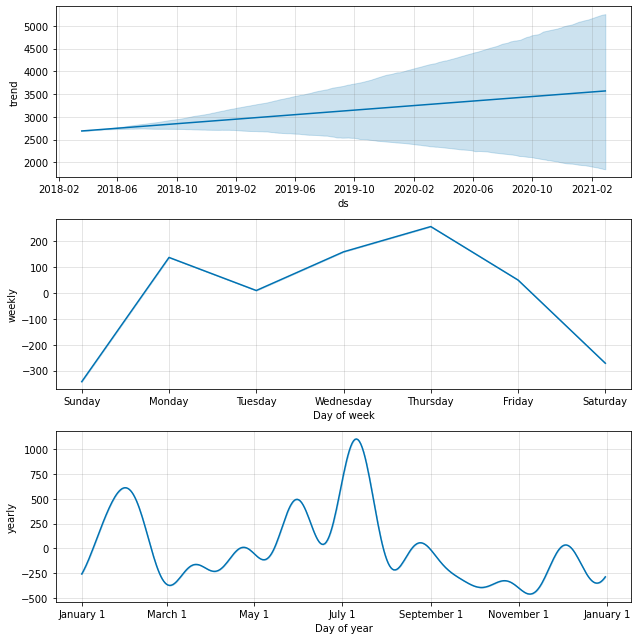

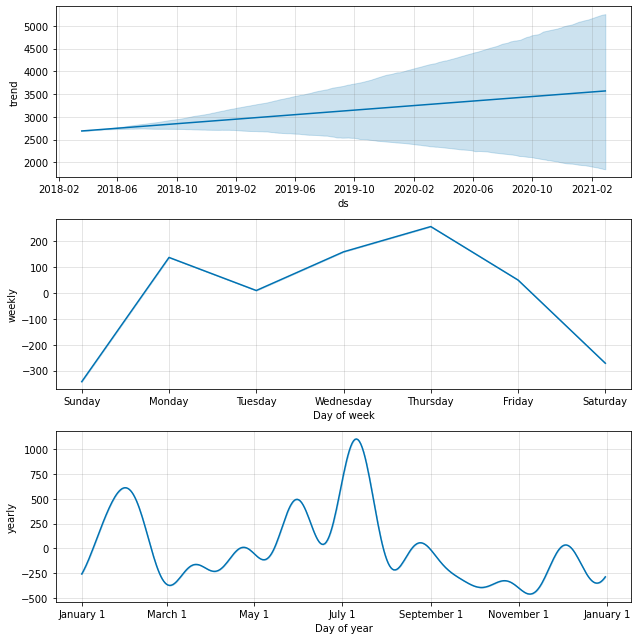

In [24]:
model.plot_components(forecast_result)

Multivariate Time Series Model

In [25]:
# Reset the index
daily_rate.reset_index(inplace=True)
daily_rate.head(2)

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01,379.2,41565.38,88.56,2751.70
1,2010-09-02,369.6,38898.99,88.56,570.81


In [26]:
# Rename the columns
dsr = daily_rate.rename(columns = {'FullDate':'ds','Tmax':'add2',
                                           'SysLoad':'add1','GasPrice':'add3',
                                           'ElecPrice':'y'})
dsr.head(3)

,ds,add2,add1,add3,y
0,2010-09-01,379.2,41565.38,88.56,2751.700
1,2010-09-02,369.6,38898.99,88.56,570.810
2,2010-09-03,439.2,41665.76,106.80,504.975


In [27]:
# Split the dataset into train and test sets
train_dsr = dsr.iloc[:2757,:]
test_dsr = dsr.iloc[2757:,:]

In [28]:
# Model implementation
model = Prophet()
model.add_regressor('add1')
model.add_regressor('add2')
model.add_regressor('add3')
model = model.fit(train_dsr)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
forecast_new_result = model.predict(test_dsr)

In [30]:
MAPE = Metric(test_dsr['y'],forecast_new_result['yhat'])
round(MAPE,2)

233.74

In [31]:
RMSE = np.sqrt(metrics.mean_squared_error(test_dsr['y'],forecast_new_result['yhat']))
round(RMSE,2)

2709.65

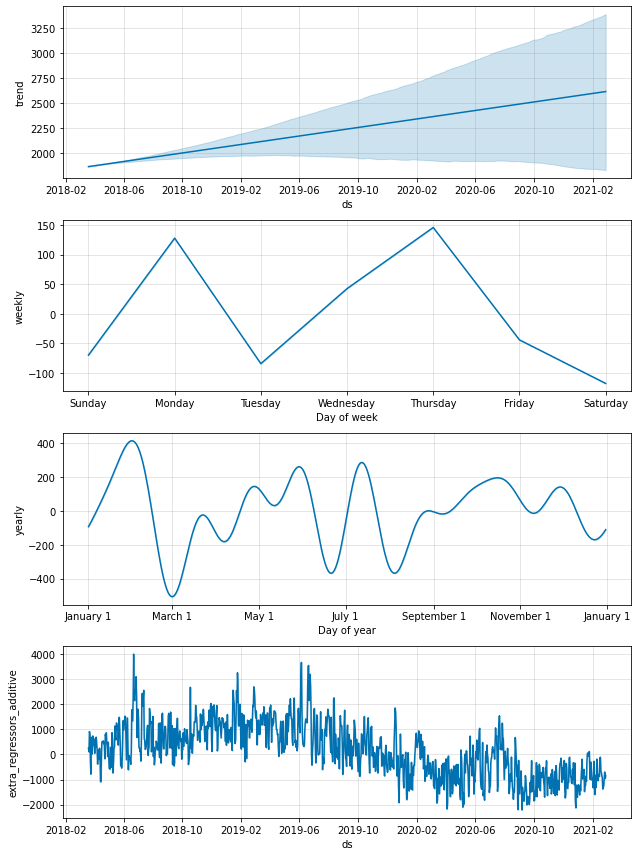

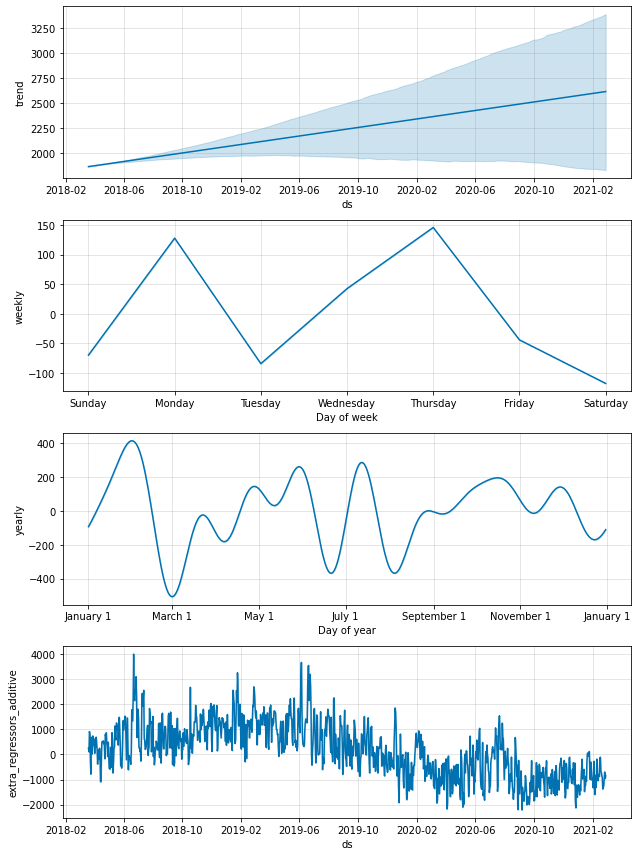

In [32]:
model.plot_components(forecast_new_result)

Multivariate Model without TMAX

In [33]:
# Split the dataset
trainData = daily_rate.iloc[:2757,:]
testData = daily_rate.iloc[2757:,:]
trainData.shape , testData.shape

((2757, 5), (1077, 5))

In [34]:
# Exclude the Tmax 
train_df = trainData.iloc[:,[0,2,3,4]]
test_df = testData.iloc[:,[0,2,3,4]]

In [35]:
# Exclude the Tmax 
train_df = trainData.iloc[:,[0,2,3,4]]
test_df = testData.iloc[:,[0,2,3,4]]
# Rename the columns
train_df = train_df.rename(columns = {'FullDate':'ds',
                                           'SysLoad':'add1','GasPrice':'add2',
                                           'ElecPrice':'y'})
test_df = test_df.rename(columns = {'FullDate':'ds',
                                           'SysLoad':'add1','GasPrice':'add2',
                                           'ElecPrice':'y'})
train_df.head(2)

,ds,add1,add2,y
0,2010-09-01,41565.38,88.56,2751.70
1,2010-09-02,38898.99,88.56,570.81


In [36]:
# Model Implementation
model = Prophet()
model.add_regressor('add1')
model.add_regressor('add2')
model = model.fit(train_df)
forecast_values_new = model.predict(test_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
MAPE = Metric(test_df['y'],forecast_values_new['yhat'])
round(MAPE,2)

236.66

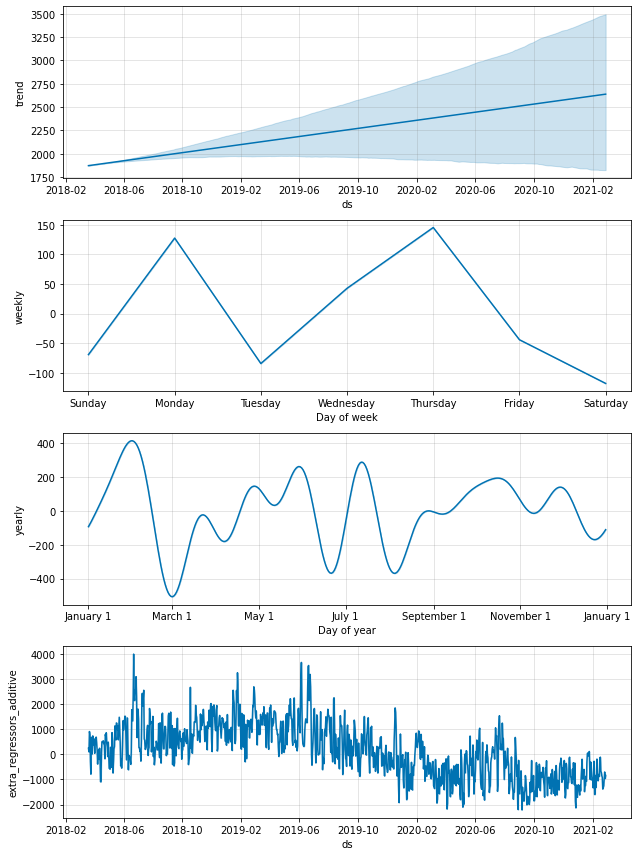

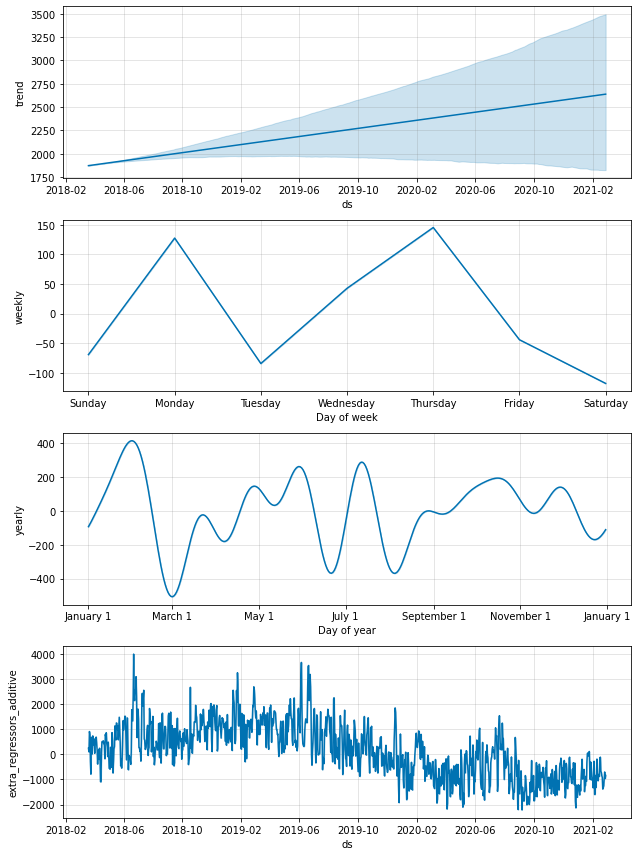

In [38]:
model.plot_components(forecast_values_new)